In [1]:
import utils.data_import as data_import
import utils.ml_utils as ml_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm

import importlib

import settings

np.random.seed(123)

/anaconda3/envs/ONE/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')
    
import matplotlib.pyplot as plt
%matplotlib inline

No cuda.


In [3]:
corpus = data_import.Corpus(file_path='/Users/ivoliv/data/wikitext/wikitext-2', lines=settings.lines)    
corpus.batchify(batch_size=settings.batch_size, seq_length=settings.window_size)

Generated train: 2,370,351 tokens
Generated valid: 245,498 tokens
Generated test:  273,186 tokens
Generated vocab: 28,913
Generated oov:   2.8%
Batchifying train... Done.  torch.Size([29629, 80])
Batchifying valid... Done.  torch.Size([3068, 80])
Batchifying test...  Done.  torch.Size([3414, 80])


In [4]:
corpus.train.show_itoklist(29629,29629+70)

3 3866 3 1624 869 346 3519 305 14 160 1894 149 10 62 1197 1791 278 1199 2685 23 2233 346 2186 44 3 3890 566 36 4186 93 3874 3875 62 16 1 3 44 2235 38 46 14 3 3850 902 44 18 3 850 848 3 4187 3 2080 127 62 3 671 127 2 3 4188 3 1668 62 563 14 4189 4190 16 3 

In [5]:
corpus.train.batch_matrix[:70,1]

tensor([   3, 3866,    3, 1624,  869,  346, 3519,  305,   14,  160, 1894,  149,
          10,   62, 1197, 1791,  278, 1199, 2685,   23, 2233,  346, 2186,   44,
           3, 3890,  566,   36, 4186,   93, 3874, 3875,   62,   16,    1,    3,
          44, 2235,   38,   46,   14,    3, 3850,  902,   44,   18,    3,  850,
         848,    3, 4187,    3, 2080,  127,   62,    3,  671,  127,    2,    3,
        4188,    3, 1668,   62,  563,   14, 4189, 4190,   16,    3])

count    441.000000
mean      67.185941
std        9.148367
min       27.000000
25%       65.000000
50%       69.000000
75%       72.000000
max       84.000000
Name: len, dtype: float64


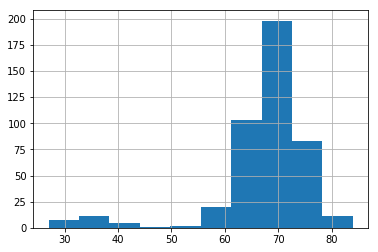

In [6]:
df = corpus.train.batch_stats()
df.hist()

In [7]:
train_dl = data_import.WikiTextDataset(corpus.train)
valid_dl = data_import.WikiTextDataset(corpus.valid)
test_dl = data_import.WikiTextDataset(corpus.test)

In [8]:
print(len(corpus.vocab))

28913


In [9]:
class simpleLSTM(nn.Module):
    def __init__(self, emb_dim, hidden_dim, n_layers=1,
                 dropout=0, bidirectional=True):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.ndir = (2 if bidirectional==True else 1)
        
        self.embedding = nn.Embedding(len(corpus.vocab), emb_dim)
        
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(self.ndir*hidden_dim, len(corpus.vocab))
        
        self.dropout = nn.Dropout(dropout)
        
        self.init_weights()
        
    def init_weights(self, initrange=0.1):
        
        self.embedding.weight.data.uniform_(-initrange, initrange) 
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                param.data.zero_()
            elif 'weight' in name:
                param.data.uniform_(-initrange, initrange)

        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, seq):
        
        #pdb.set_trace()
        # seq dims: [seq len, batch size]
        
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        
        out, (hid, cel) = self.lstm(emb)
        
        # out dims: [seq len, batch size, hidden_dim]
        # hid dims: [2*n_layers, batch size, hidden_dim]
        # cel dims: [2*n_layers, batch size, hidden_dim]
        # out[-1,:,:hd] -> [batch size, hidden_dim]  (last time step hidden vector)
        # out[0,:,hd:] <- [batch size, hidden_dim]  (first time step hidden vector)
        # contatenation of last time period, whole batch, forward (first) chunck of hidden units
        #   and the first time period, whole batch, backward (last) chunck of hidden units
        #   (pytorch concatenates hidden units across dim #2 for bidirectional LSTM)
        #if self.ndir == 2:
        #    conc = torch.cat((out[-1,:,:self.hidden_dim], out[0,:,self.hidden_dim:]), dim=1)
        #else:
        #    conc = out[0,:,self.hidden_dim]
        
        output = self.dropout(out)
        
        output = self.fc(output)
        
        # sm dims: [batch size, n_classes]
        #sm = F.log_softmax(output, dim=-1)
        #return sm
    
        return output

In [10]:
model = simpleLSTM(emb_dim=settings.emb_dim,
                   hidden_dim=settings.hidden_dim,
                   n_layers=settings.num_layers,
                   dropout=settings.dropout
                  )

In [11]:
if cuda:
    model = model.cuda()

In [12]:
print(model)

simpleLSTM(
  (embedding): Embedding(28913, 400)
  (lstm): LSTM(400, 1150, num_layers=3, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=2300, out_features=28913, bias=True)
  (dropout): Dropout(p=0.4)
)


In [13]:
missclass = []
missclass_next = []
losses = []

In [14]:
from tqdm import tqdm
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()

                preds = model(x)
                loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0)

                _, y_preds = torch.max(preds, dim=2)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)*y.size(1)
                
                miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals
            miss_next_wd_rate_tr = miss_next_wd / next_wd_tot

            epoch_loss = running_loss / len(trn)

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    preds = model(x)
                    loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                    val_loss += loss.item() * x.size(0)

                    _, y_preds = torch.max(preds, dim=2)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)*y.size(1)
                    
                    miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                    next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(vld)
            
            miss_next_wd_rate_val = miss_next_wd / next_wd_tot
            
            missclass_next.append((miss_next_wd_rate_tr, miss_next_wd_rate_val))
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Ppl: [{:6.2f}, {:6.2f}], Miss: [{:.2%}, {:.2%}], [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          math.exp(epoch_loss), math.exp(val_loss), 
                          missclass_tr, missclass_te,
                          miss_next_wd_rate_tr, miss_next_wd_rate_val))
            sys.stdout.flush()

            print('Saving weights file...', end=' ', flush=True)
            torch.save(model, 'model_weights.pt')
            print('Done.', flush=True)
            #to load: model = torch.load('model_weights.pt')
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [15]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Train 1/10:   0%|          | 0/441 [00:00<?, ?it/s]

Stopping with latest weights.


In [16]:
x, y = next(iter(valid_dl))
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=2)
ml_utils.calc_miss_next_wds(y, y_preds)

2
64
64
64
64
64
1
64
49
58
64
64
64
64
64
64
64
30
64
64
14
64
64
64
64
64
64
64
64
64
26
64
64
32
64
64
64
64
14
64
22
64
64
64
64
64
64
64
26
4
43
64
3
8
64
64
59
64
64
64
64
10
64
34
61
64
8
64
64
64
2
64
64
64
30
64
64
11
1
64


80

In [17]:
print(y.shape)
y[:,2]

torch.Size([65, 80])


tensor([    2,    23,     2,   269,    16,     3,    18,   897,    17,    18,
         3408,   130,  1089,    44,  1763,   215,    18,  4187,   524,   130,
         1670,  1950,    23,     3,  5474,     3,   511,    16,     3,  1099,
           31,  2149,   130,  3472,    23,  5543,    18,     3,  1035, 10994,
        10619,  1036,    17,     3,  5474,     3,   511,    23,     3, 13525,
            3,  7542,    14,    38,  2653,     3,  1099,    31,  3511,   776,
            3, 13525,     3,  7542,    38])

In [18]:
y_preds[:,2]

tensor([ 9249,  5496,  1534, 20256,  7244, 14899, 12361, 23518, 18429, 13557,
        12660, 15891, 18656, 25438, 18878, 15756, 15639, 28171, 25163,   144,
         3318, 13891, 19153, 20029,  5717,  7117,  1240, 17988, 25703, 21371,
        24293,  4311,  5939,  4373, 16156, 24091, 26650, 20189, 16181, 22186,
         5028, 11321, 23634, 24978,  9618, 19051, 28475,  8254,  6554, 23920,
        18676, 18676, 17340, 12064, 13656,  7769, 11106, 19645, 21558, 26099,
        28797,  9302, 23427, 26486, 24151])

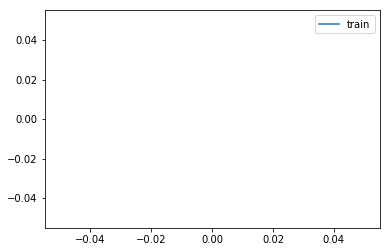

In [19]:
plt.plot(losses)
plt.legend(['train', 'valid'])

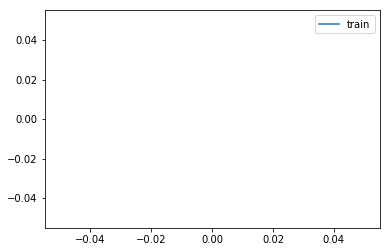

In [20]:
plt.plot(missclass)
plt.legend(['train', 'valid'])

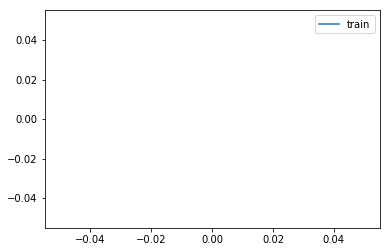

In [21]:
plt.plot(missclass_next)
plt.legend(['train', 'valid'])